# Ideas
    1. Download many stock datasets OK
    2. Display nicely those stock datasets Almost OK
    3. Make some data preprocessing - like values only from -1 to 1or sth
    4. Implement some prediction-like algorithms
    5. Make and display predictions
    6. Make and display future predictions :o

## Imports and Some Settings

In [5]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.optimizers as opti
import tensorflow.keras.activations as acti
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import pandas_datareader
from datetime import date

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True))
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Some Consts and "Consts"

In [2]:
# Consts
DATA_SRC = 'yahoo'
START_DATE = '2012-01-01'

# Almost Const
END_DATE = date.today().strftime("%Y-%m-%d")

# Super Hiper Important - Names and "Short Names" of Companies to get their stock prices from web
COMPANIES = {"Apple Inc.": "AAPL",
                  "Tesla Inc.": "TSLA",
                  "Netflix Inc.": "NFLX",
                  "Amazon.com Inc.": "AMZN",
                  "Alphabet Inc.": "GOOG",
                  "Facebook Inc.": "FB"}

## Loading Datasets

In [3]:
def read_dataset_from_web(dataset_short, data_src=DATA_SRC, start_date=START_DATE, end_date=END_DATE):
    return pandas_datareader.DataReader(dataset_short, data_source=data_src, start=start_date, end=end_date) 

In [6]:
all_raw_datasets = [read_dataset_from_web(COMPANIES[name_short]) for name_short in COMPANIES]
datasets = [buf.filter(['Close']).values for buf in all_raw_datasets]

## Displaying Real Datasets

In [7]:
def display_datasets(sets, datasets, names, title, xlabel, ylabel):
    """
    Displays given datasets
    :param sets: size of figure and position for subplots
    :param datasets: list of datasets
    :param names: names of the companies
    :param title: top title of subplot
    :param xlabel: text for xlabel :o
    :param ylabel: text for ylabel :o
    """
    sub = fig.add_subplot(sets[0], sets[1], sets[2])
    sub.set_title(title, fontsize=24)
    sub.set_xlabel(xlabel, fontsize=20)
    sub.set_ylabel(ylabel, fontsize=20)
    
    for ii in range(len(datasets)):
        y = datasets[ii]
        label = names[ii]
        sub.plot(y, label=label)
    sub.legend(fontsize=16)
    sub.grid()

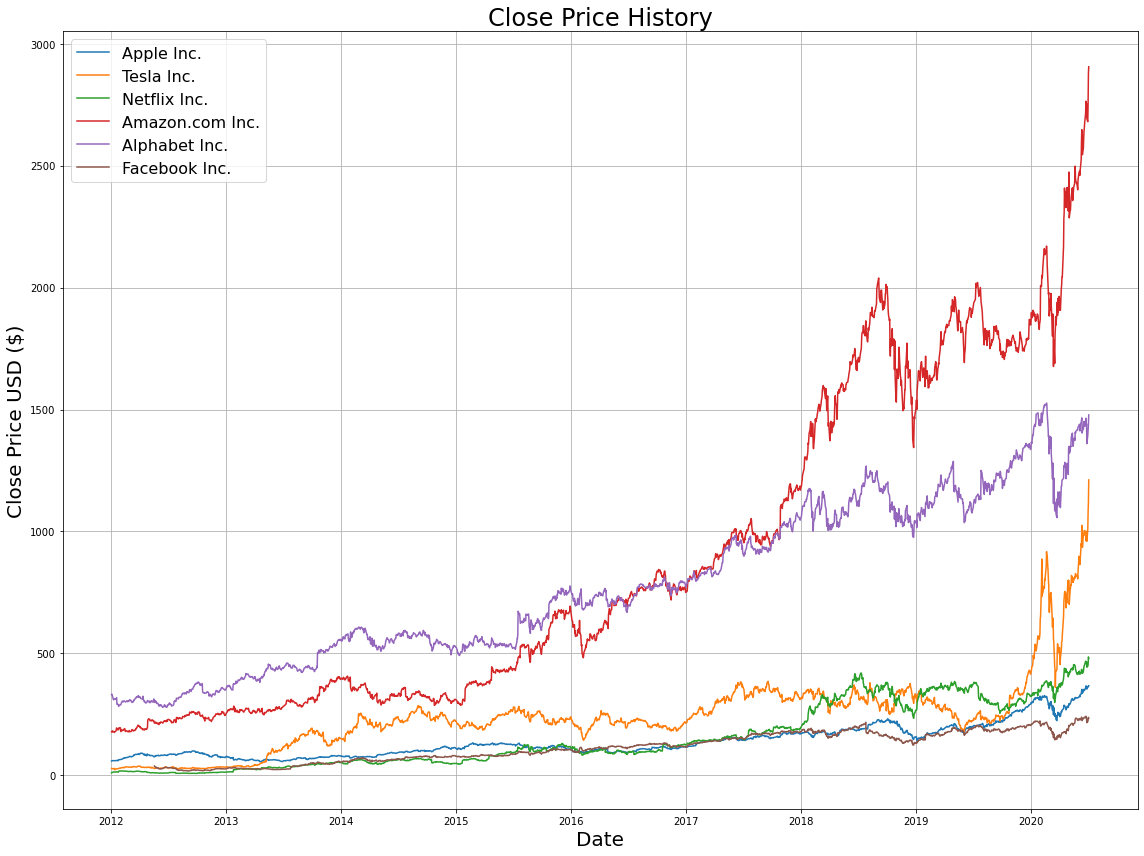

In [10]:
all_raw_datasets_close = [buf['Close'] for buf in all_raw_datasets]
fig = plt.figure(figsize=(16, 12))
display_datasets((1,1,1), all_raw_datasets_close, list(COMPANIES.keys()), 'Close Price History', 'Date', 'Close Price USD ($)')
plt.tight_layout()
plt.draw()

## Data Preprocessing

## Some Models 

## Training / Fitting Models

## Evaluating Models - Predictions

## Predictions for Future :o